In [2]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -4", force=True))
import pickle
import gzip
import copy
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision
from curriculum_deeplab.data_parameters import DataParamMode
import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import visualize_seg
from curriculum_deeplab.mindssc import mindssc

from pathlib import Path

import wandb
import random
import glob
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name      Util    Mem free  Cuda             User(s)
----  -----------  ------  ----------  ---------------  ------------
   0  TITAN RTX       0 %   10341 MiB  11.2(460.73.01)  root, hansen

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   1  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.0a0+gitdfbd030
8204
NVIDIA GeForce RTX 2080 Ti


In [3]:
def in_notebook():
    try:
        get_ipython().__class__.__name__
        return True
    except NameError:
        return False

if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))
print(f"Running in: {THIS_SCRIPT_DIR}")

Running in: /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab


In [3]:
import glob
import pandas as pd
corrs = {}
def get_corr_coeff(inp):
    return np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy(), inp)[0,1]

for pth in glob.glob('./data/output/**/*.pth'):
    print(pth)
    data = torch.load(pth)
    dp_mean_weight, *_, d_ids, dataset_idxs, _2d_labels, _2d_modified_labels = data
    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_labels.sum((-2,-1))
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(pp_sum+gt_sum)
    all_elems = dict(
            gt_sum=get_corr_coeff(gt_sum),
            intersect=get_corr_coeff(intersect),
            pp_sum=get_corr_coeff(pp_sum),
            sqrt=get_corr_coeff(np.sqrt(gt_sum)),
            log=get_corr_coeff(np.log(gt_sum+gt_sum.max().sqrt())), # this seems to be right
            dice=get_corr_coeff(dice)
    )
    corrs[pth.split('/')[-2]] = all_elems
    # break
df = pd.DataFrame(corrs)
df.to_csv('pd.csv')
print(df)


./data/output/_summer-sound-913_fold0_epx39/train_label_snapshot.pth


KeyboardInterrupt: 

In [4]:
data = torch.load('/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/_clean-morning-918_fold0_epx39/train_label_snapshot.pth')
dp_mean_weight, disturb_flags, d_ids, dataset_idxs, _2d_labels, _2d_modified_labels, _2d_predictions = data
print(len(dp_mean_weight))

2212


In [5]:
gt_sum = _2d_modified_labels.sum((-2,-1))
pp_sum = _2d_predictions.sum((-2,-1)).squeeze(1).cpu()
rgt_sum =  _2d_labels.sum((-2,-1)).cpu()
intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
dice = 2*intersect/(rgt_sum+gt_sum+1)
all_elems = \
    dict(
        gt_sum=gt_sum, 
        dice=dice, 
        pp_sum=pp_sum,
        sqrt_gt_sum=np.sqrt(gt_sum),
        log_gt_sum=np.log(gt_sum+1)+1, # this seems to be right
        e_log_gt_sum=torch.tensor(dp_mean_weight)/(np.log(gt_sum+np.exp(1))+np.exp(1))
    )


In [6]:
for name, metric in all_elems.items():
    print(name, np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy(), metric)[0,1])


gt_sum 0.8242536552818129
dice 0.6335904766732602
pp_sum 0.799543165879448
sqrt_gt_sum 0.7038407582628009
log_gt_sum 0.49262799510469135
e_log_gt_sum 0.8325085837655076


In [7]:
print("Corr coeff DP weight vs. DP reweight with", name, np.corrcoef(torch.tensor(dp_mean_weight)/all_elems['e_log_gt_sum'].cpu().detach().numpy(), dice)[0,1])

Corr coeff DP weight vs. DP reweight with e_log_gt_sum 0.7811313871631291


cerulean-thunder-1018_fold0_epx59/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.8278054469506166
dice 0.8095933224664398
pp_sum 0.8200475012664931
sqrt_gt_sum 0.7831021758690532
log_gt_sum 0.6618948166652153
e_log_gt_sum 0.6739964577386311
inv_e_log_gt_sum -0.6168721418098405
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with gt_sum 0.67
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with pp_sum 0.69
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with sqrt_gt_sum 0.67
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with log_gt_sum 0.75
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with e_log_gt_sum 0.83
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with inv_e_log_gt_sum 0.68


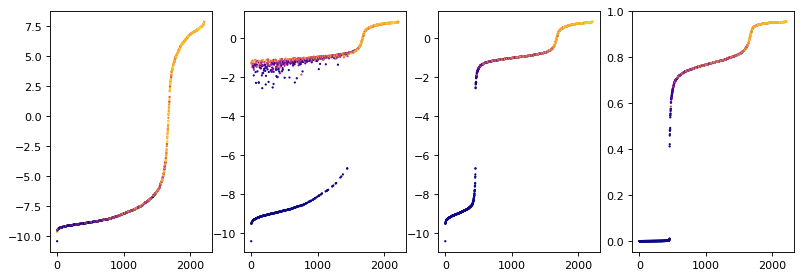

In [8]:

reweighted = torch.tensor(dp_mean_weight)/(all_elems['log_gt_sum'])

sel_idxs = reweighted<100
srtd_reweighted = reweighted[sel_idxs]
srtd_dice_reweighted = dice[sel_idxs]

srtd = sorted(zip(srtd_reweighted, srtd_dice_reweighted))
srtd_reweighted, srtd_dice_reweighted = zip(*srtd)
srtd_reweighted, srtd_dice_reweighted = torch.stack(srtd_reweighted), torch.stack(srtd_dice_reweighted)

# Show weights and weights with compensation
fig, axs = plt.subplots(1,4, figsize=(12, 4), dpi=80)
sc1 = axs[0].scatter(
    range(len(dp_mean_weight)), 
    torch.tensor(dp_mean_weight).cpu().detach().numpy(), c=dice,s=1, cmap='plasma');
sc2 = axs[1].scatter(
    range(len(dp_mean_weight)), 
    reweighted.cpu().detach().numpy(), 
    s=1,c=dice, cmap='plasma')
sc3 = axs[2].scatter(
    range(len(srtd_reweighted)), 
    srtd_reweighted.detach().numpy(), 
    s=1,c=srtd_dice_reweighted, cmap='plasma');
# plt.colorbar()
sc4 = axs[3].scatter(
    range(len(srtd_reweighted)), 
    torch.sigmoid(srtd_reweighted-srtd_reweighted.mean()).detach().numpy(), 
    s=1,c=srtd_dice_reweighted, cmap='plasma');
plt.show()

sg_reweighted = torch.sigmoid(reweighted-reweighted.mean())

In [137]:
def interpolate_sample(b_image=None, b_label=None, scale_factor=1.,
                       yield_2d=False):
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'

    if b_image is not None:
        b_image = F.interpolate(
            b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True,
            recompute_scale_factor=False
        )
        b_image = b_image.squeeze(1)

    if b_label is not None:
        b_label = F.interpolate(
            b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest',
            recompute_scale_factor=False
        ).long()
        b_label = b_label.squeeze(1)

    return b_image, b_label
    
data = zip(sg_reweighted, d_ids, _2d_labels, _2d_modified_labels, _2d_predictions)


samples_sorted = sorted(data, key=lambda tpl: tpl[0])
(dp_weightss, d_idss, _2d_lbl, _2d_ml, _2d_p) = zip(*samples_sorted)

overlay_text_list = [f"id:{d_id} gwd:{instance_p.item():.2f}" \
    for d_id, instance_p in zip(d_idss, dp_weightss)]

visualize_seg(in_type="batch_2D",
    img=interpolate_sample(b_label=torch.stack(_2d_lbl), scale_factor=.5, yield_2d=True)[1].unsqueeze(1),
    seg=interpolate_sample(b_label=4*torch.stack(_2d_p).squeeze(1), scale_factor=.5, yield_2d=True)[1],
    ground_truth=interpolate_sample(b_label=torch.stack(_2d_ml), scale_factor=.5, yield_2d=True)[1],
    crop_to_non_zero_seg=False,
    alpha_seg = .5,
    alpha_gt = .5,
    n_per_row=70,
    overlay_text=overlay_text_list,
    annotate_color=(0,255,255),
    file_path="out_reweight.png",
)

In [9]:
torch.save(
    {
        'reweighted_weigths': sg_reweighted,
        'd_ids': d_ids 
    }, 
    'fixed_weights.pth'
)


In [ ]:
correction = \
    [
        1.0,
        1/(1+gt_sum).numpy(), 
        1/(1+np.sqrt(gt_sum)).numpy(),
        1/np.log(gt_sum+gt_sum.max().sqrt()).numpy(),
    ]

for crr in correction:
    print(np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy()*crr, dice)[0,1])


In [ ]:
import glob
import pandas as pd
corrs = {}
def get_corr_coeff(inp):
    return np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy(), inp)[0,1]

            if do_affine:
                affine_matrix = (torch.eye(2,3).unsqueeze(0) + \
                    affine_strength * (1/10*torch.randn(B,2,3)+1.)).to(common_device)

                affine_disp = F.affine_grid(affine_matrix, torch.Size((B,1,H,W)),
                                        align_corners=False)
                grid += (affine_disp-id_grid)

        else:
            assert len(common_shape) == 4, \
                f"Augmenting 3D. Input batch " \
                f"should be BxDxHxW but is {common_shape}."
            B,D,H,W = common_shape

            identity = torch.eye(3,4).expand(B,3,4).to(common_device)
            id_grid = F.affine_grid(identity, torch.Size((B,3,D,H,W)),
                align_corners=False)

            grid = id_grid

            if do_bspline:
                bspline = torch.nn.Sequential(
                    nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
                    nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
                    nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2))
                ).to(b_image.device)
                dim_strength = (torch.tensor([D,H,W]).float()*bspline_strength).to(common_device)

                rand_control_points = dim_strength.view(1,3,1,1,1)  * \
                    (
                        1/10*torch.randn(B, 3, bspline_num_ctl_points, bspline_num_ctl_points, bspline_num_ctl_points)+1.
                    ).to(b_image.device)

                bspline_disp = bspline(rand_control_points)

                bspline_disp = torch.nn.functional.interpolate(
                    bspline_disp, size=(D,H,W), mode='trilinear', align_corners=True
                ).permute(0,2,3,4,1)

                grid += bspline_disp

            if do_affine:
                affine_matrix = (torch.eye(3,4).unsqueeze(0) + \
                    affine_strength * (1/10*torch.randn(B,3,4)+1.)).to(common_device)

                affine_disp = F.affine_grid(affine_matrix,torch.Size((B,1,D,H,W)),
                                        align_corners=False)

                grid += (affine_disp-id_grid)
    else:
        # Override grid with external value
        grid = b_grid_override

    if b_image is not None:
        b_image_out = F.grid_sample(
            b_image.unsqueeze(1).float(), grid,
            padding_mode='border', align_corners=False)
        b_image_out = b_image_out.squeeze(1)
    else:
        b_image_out = None

    if b_label is not None:
        b_label_out = F.grid_sample(
            b_label.unsqueeze(1).float(), grid,
            mode='nearest', align_corners=False)
        b_label_out = b_label_out.squeeze(1).long()
    else:
        b_label_out = None

    b_out_grid = grid

    if pre_interpolation_factor:
        b_image_out, b_label_out = interpolate_sample(
            b_image_out, b_label_out,
            1/pre_interpolation_factor, yield_2d
        )

        b_out_grid = F.interpolate(b_out_grid.permute(0,3,1,2),
                      scale_factor=1/pre_interpolation_factor, mode='bilinear',
                      align_corners=True, recompute_scale_factor=False).permute(0,2,3,1)

    return b_image_out, b_label_out, b_out_grid



def augmentNoise(b_image, strength=0.05):
    return b_image + strength*torch.randn_like(b_image)

In [ ]:
class CrossMoDaHealed_Data(Dataset):
    def __init__(self,
        base_dir, domain, state,
        ensure_labeled_pairs=True, use_additional_data=False, resample=True,
        size:tuple=(96,96,60), normalize:bool=True,
        max_load_num=None, crop_3d_w_dim_range=None, crop_2d_slices_gt_num_threshold=None,
        disturbed_idxs=None, disturbance_mode=None, disturbance_strength=1.0,
        yield_2d_normal_to=None, flip_r_samples=True,
        dilate_kernel_sz=1,
        debug=False
    ):

        """
        Function to create Dataset structure with crossMoDa data.
        The function allows to use different preproccessing steps of the crossMoDa data set
        and using additinal data from TCIA database.
        The data can also be resampled to a desired size and normalized to mean=0 and std=1.

        Parameters:
                base_dir (os.Pathlike): provide the directory which contains "L1..." to "L4..." directories
                domain (str): choose which domain to load. Can be set to "source", "target" or "validation". Source are ceT1, target and validation hrT2 images.

                state (str): state of preprocessing:    "l1" = original data,
                                                        "l2" = resampled data @ 0.5mm,
                                                        "l3" = center-cropped data,
                                                        "l4" = image specific crops for desired anatomy

                ensure_labeled_pairs (bool): Only images with corresponding labels will be loaded (default: True)

                use_additional_data (bool): set to True to use additional data from TCIA (default: False)

                resample (bool): set to False to disable resampling to desired size (default: True)

                size (tuple): 3d-tuple(int) to which the data is resampled. Unused if resample=False. (default: (96,96,60)).
                    WARNING: choosing large sizes or not resampling can lead to excess memory usage

                normalize (bool): set to False to disable normalization to mean=0, std=1 for each image (default: True)
                max_load_num (int): maximum number of pairs to load (uses first max_load_num samples for either images and labels found)
                crop_3d_w_dim_range (tuple): Tuple of ints defining the range to which dimension W of (D,H,W) is cropped
                yield_2d_normal_to (bool):

        Returns:
                torch.utils.data.Dataset containing CrossMoDa data

        Useful Links:
        CrossMoDa challenge:
        https://crossmoda.grand-challenge.org/

        ToDos:
            extend to other preprocessing states

        Example:
            dataset = CrossMoDa_source('original')

            data = dataset.get_data()

        """

        self.disturbed_idxs = disturbed_idxs
        self.yield_2d_normal_to = yield_2d_normal_to
        self.crop_2d_slices_gt_num_threshold = crop_2d_slices_gt_num_threshold
        self.do_augment = False
        self.do_disturb = False
        self.augment_at_collate = False
        self.dilate_kernel_sz = dilate_kernel_sz
        self.disturbance_mode = disturbance_mode
        self.disturbance_strength = disturbance_strength

        #define finished preprocessing states here with subpath and default size
        states = {
            'l1':('L1_original/', (512,512,160)),
            'l2':('L2_resampled_05mm/', (420,420,360)),
            'l3':('L3_coarse_fixed_crop/', (128,128,192)),
            'l4':('L4_fine_localized_crop/', (128,128,128))
        }
        t0 = time.time()
        #choose directory with data according to chosen preprocessing state
        if state not in states: raise Exception("Unknown state. Choose one of: "+str(states.keys))

        state_dir = states[state.lower()][0] #get sub directory

        if not resample: size = states[state.lower()][1] #set size to default defined at top of file

        path = base_dir + state_dir

        #get file list
        if domain.lower() =="ceT1" or domain.lower() =="source":
            directory = "source_training_labeled/"
            add_directory = "__additional_data_source_domain__"
            domain = "ceT1"

        elif domain.lower() =="hrT2" or domain.lower() =="target":
            directory = "target_training_unlabeled/"
            add_directory = "__additional_data_target_domain__"
            domain = "hrT2"

        elif domain.lower() =="validation":
            directory = "target_validation_unlabeled/"

        else:
            raise Exception("Unknown domain. Choose either 'source', 'target' or 'validation'")

        files = sorted(glob.glob(os.path.join(path+directory , "*.nii.gz")))

        if domain == "hrT2":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_training__" , "*.nii.gz")))

        if domain.lower() == "validation":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_validation__" , "*.nii.gz")))

        if use_additional_data and domain.lower() != "validation": #add additional data to file list
            files = files+sorted(glob.glob(os.path.join(path+add_directory , "*.nii.gz")))
            files = [i for i in files if "additionalLabel" not in i] #remove additional label files

        # First read filepaths
        self.img_paths = {}
        self.label_paths = {}

        if debug:
            files = files[:4]

        for _path in files:

            numeric_id = int(re.findall(r'\d+', os.path.basename(_path))[0])
            if "_l.nii.gz" in _path or "_l_Label.nii.gz" in _path:
                lr_id = 'l'
            elif "_r.nii.gz" in _path or "_r_Label.nii.gz" in _path:
                lr_id = 'r'
            else:
                lr_id = ""

            # Generate crossmoda id like 004r
            crossmoda_id = f"{numeric_id:03d}{lr_id}"

            if "Label" in _path:
                self.label_paths[crossmoda_id] = _path

            elif domain in _path:
                self.img_paths[crossmoda_id] = _path

        if ensure_labeled_pairs:
            pair_idxs = set(self.img_paths).intersection(set(self.label_paths))
            self.label_paths = {_id: _path for _id, _path in self.label_paths.items() if _id in pair_idxs}
            self.img_paths = {_id: _path for _id, _path in self.img_paths.items() if _id in pair_idxs}


        # Populate data
        self.img_data_3d = {}
        self.label_data_3d = {}

        self.img_data_2d = {}
        self.label_data_2d = {}
        self.modified_label_data_2d = {}

        #load data

        print("Loading CrossMoDa {} images and labels...".format(domain))
        id_paths_to_load = list(self.label_paths.items()) + list(self.img_paths.items())

        description = f"{len(self.img_paths)} images, {len(self.label_paths)} labels"

        for _3d_id, _file in tqdm(id_paths_to_load, desc=description):
            # tqdm.write(f"Loading {f}")
            if "Label" in _file:
                tmp = torch.from_numpy(nib.load(_file).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='nearest').squeeze()

                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)

                if crop_3d_w_dim_range:
                    tmp = tmp[..., crop_3d_w_dim_range[0]:crop_3d_w_dim_range[1]]

                # Only use tumour class, remove TODO
                tmp[tmp==2] = 0
                self.label_data_3d[_3d_id] = tmp.long()

            elif domain in _file:
                tmp = torch.from_numpy(nib.load(_file).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='trilinear',align_corners=False).squeeze()

                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)

                if crop_3d_w_dim_range:
                    tmp = tmp[..., crop_3d_w_dim_range[0]:crop_3d_w_dim_range[1]]

                if normalize: #normalize image to zero mean and unit std
                    tmp = (tmp - tmp.mean()) / tmp.std()

                self.img_data_3d[_3d_id] = tmp

        # Postprocessing of 3d volumes
        for _3d_id in list(self.label_data_3d.keys()):
            if self.label_data_3d[_3d_id].unique().numel() != 2: #TODO use 3 classes again
                del self.img_data_3d[_3d_id]
                del self.label_data_3d[_3d_id]
            elif "r" in _3d_id:
                self.img_data_3d[_3d_id] = self.img_data_3d[_3d_id].flip(dims=(1,))
                self.label_data_3d[_3d_id] = self.label_data_3d[_3d_id].flip(dims=(1,))

        if max_load_num and ensure_labeled_pairs:
            for _3d_id in list(self.label_data_3d.keys())[max_load_num:]:
                del self.img_data_3d[_3d_id]
                del self.label_data_3d[_3d_id]

        elif max_load_num:
            for del_key in list(self.img_data_3d.keys())[max_load_num:]:
                del self.img_data_3d[del_key]
            for del_key in list(self.label_data_3d.keys())[max_load_num:]:
                del self.label_data_3d[del_key]

        #check for consistency
        print("Equal image and label numbers: {}".format(set(self.img_data_3d)==set(self.label_data_3d)))

        img_stack = torch.stack(list(self.img_data_3d.values()), dim=0)
        img_mean, img_std = img_stack.mean(), img_stack.std()

        label_stack = torch.stack(list(self.label_data_3d.values()), dim=0)

        print("Image shape: {}, mean.: {:.2f}, std.: {:.2f}".format(img_stack.shape, img_mean, img_std))
        print("Label shape: {}, max.: {}".format(label_stack.shape,torch.max(label_stack)))

        if yield_2d_normal_to:
            if yield_2d_normal_to == "D":
                slice_dim = -3
            if yield_2d_normal_to == "H":
                slice_dim = -2
            if yield_2d_normal_to == "W":
                slice_dim = -1

            for _3d_id, image in self.img_data_3d.items():
                for idx, img_slc in [(slice_idx, image.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(image.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.img_data_2d[f"{_3d_id}{yield_2d_normal_to}{idx:03d}"] = img_slc

            for _3d_id, label in self.label_data_3d.items():
                for idx, lbl_slc in [(slice_idx, label.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(label.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.label_data_2d[f"{_3d_id}{yield_2d_normal_to}{idx:03d}"] = lbl_slc

        # Postprocessing of 2d slices

        rem_sum = 0
        for key, label in list(self.label_data_2d.items()):
            uniq_vals = label.unique()

            # if uniq_vals.max() == 0:
            #     # Delete empty 2D slices (but keep 3d data)
            #     del self.label_data_2d[key]
            #     del self.img_data_2d[key]
            if sum(label[label > 0]) < self.crop_2d_slices_gt_num_threshold:
                # Delete 2D slices with less than n gt-pixels (but keep 3d data)
                del self.label_data_2d[key]
                del self.img_data_2d[key]

        print("Data import finished.")
        print(f"CrossMoDa loader will yield {'2D' if self.yield_2d_normal_to else '3D'} samples")

    def get_3d_ids(self):
        return sorted(list(
            set(self.img_data_3d.keys())
            .union(set(self.label_data_3d.keys()))
        ))

    def get_2d_ids(self):
        return sorted(list(
            set(self.img_data_2d.keys())
            .union(set(self.label_data_2d.keys()))
        ))

    def get_id_dicts(self):

        all_3d_ids = self.get_3d_ids()
        id_dicts = []

        for _2d_dataset_idx, _2d_id in enumerate(self.get_2d_ids()):
            _3d_id = _2d_id[:-4]
            id_dicts.append(
                {
                    '2d_id': _2d_id,
                    '2d_dataset_idx': _2d_dataset_idx,
                    '3d_id': _3d_id,
                    '3d_dataset_idx': all_3d_ids.index(_3d_id),
                }
            )

        return id_dicts

    def __len__(self, yield_2d_override=None):
        if yield_2d_override == None:
            # Here getting 2D or 3D data length
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override

        if yield_2d:
            return len(self.img_data_2d)

        return len(self.img_data_3d)

    def __getitem__(self, dataset_idx, yield_2d_override=None):

        if yield_2d_override == None:
            # Here getting 2D or 3D data can be overridden
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override

        if yield_2d:
            all_ids = self.get_2d_ids()
            _id = all_ids[dataset_idx]
            image = self.img_data_2d.get(_id, torch.tensor([]))
            label = self.label_data_2d.get(_id, torch.tensor([]))

            # For 2D crossmoda id cut last 4 "003rW100"
            image_path = self.img_paths[_id[:-4]]
            label_path = self.label_paths[_id[:-4]]

        else:
            all_ids = self.get_3d_ids()
            _id = all_ids[dataset_idx]
            image = self.img_data_3d.get(_id, torch.tensor([]))
            label = self.label_data_3d.get(_id, torch.tensor([]))

            image_path = self.img_paths[_id]
            label_path = self.label_paths[_id]

        modified_label = self.modified_label_data_2d.get(_id, label.detach().clone())
        spat_augment_grid = []


        if self.do_augment and not self.augment_at_collate:
            b_image = image.unsqueeze(0).cuda()
            b_label = label.unsqueeze(0).cuda()
            b_modified_label = modified_label.unsqueeze(0).cuda()

            b_image, b_label, b_spat_augment_grid = self.augment(
                b_image, b_label, yield_2d
            )
            _, b_modified_label, _ = spatial_augment(
                b_label=b_modified_label, yield_2d=yield_2d, b_grid_override=b_spat_augment_grid
            )

            image = b_image.squeeze(0).cpu()
            label = b_label.squeeze(0).cpu()
            modified_label = b_modified_label.squeeze(0).cpu()
            spat_augment_grid = b_spat_augment_grid.squeeze(0).detach().cpu().clone()

        if yield_2d:
            assert image.dim() == label.dim() == 2
        else:
            assert image.dim() == label.dim() == 3

        return {
            'image': image,
            'label': label,
            'modified_label': modified_label,
            # if disturbance is off, modified label is equals label
            'dataset_idx': dataset_idx,
            'id': _id,
            'image_path': image_path,
            'label_path': label_path,
            'spat_augment_grid': spat_augment_grid
        }

    def get_3d_item(self, _3d_dataset_idx):
        return self.__getitem__(_3d_dataset_idx, yield_2d_override=False)

    def get_data(self, yield_2d_override=None):
        if yield_2d_override == None:
            # Here getting 2D or 3D data can be overridden
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override

        if yield_2d:
            img_stack = torch.stack(list(self.img_data_2d.values()), dim=0)
            label_stack = torch.stack(list(self.label_data_2d.values()), dim=0)
        else:
            img_stack = torch.stack(list(self.img_data_3d.values()), dim=0)
            label_stack = torch.stack(list(self.label_data_3d.values()), dim=0)

        return img_stack, label_stack

    def set_disturbed_idxs(self, idxs):
        if idxs is not None:
            if isinstance(idxs, (np.ndarray, torch.Tensor)):
                idxs = idxs.tolist()

            self.disturbed_idxs = idxs
        else:
            self.disturbed_idxs = []


    def train(self, augment=True, disturb=True):
        self.do_augment = augment
        self.do_disturb = disturb

    def eval(self, augment=False, disturb=False):
        self.train(augment, disturb)

    def set_augment_at_collate(self):
        self.augment_at_collate = True

    def unset_augment_at_collate(self):
        self.augment_at_collate = False

    def set_dilate_kernel_size(self, sz):
        self.dilate_kernel_sz = max(1,sz)

    def set_disturbance_strength(self, strength):
        self.disturbance_strength = strength

    def get_dilate_kernel_size(self):
        return self.dilate_kernel_sz

    def get_efficient_augmentation_collate_fn(self):
        yield_2d = True if self.yield_2d_normal_to else False

        def collate_closure(batch):
            batch = torch.utils.data._utils.collate.default_collate(batch)
            if self.augment_at_collate:
                # Augment the whole batch not just one sample
                b_image = batch['image'].cuda()
                b_label = batch['label'].cuda()
                b_image, b_label = self.augment(b_image, b_label, yield_2d)
                batch['image'], batch['label'] = b_image.cpu(), b_label.cpu()

            return batch

        return collate_closure

    def augment(self, b_image, b_label, yield_2d,
        noise_strength=0.05,
        bspline_num_ctl_points=6, bspline_strength=0.002, bspline_probability=.95,
        affine_strength=0.03, affine_probability=.45,
        pre_interpolation_factor=2.):

        if yield_2d:
            assert b_image.dim() == b_label.dim() == 3, \
                f"Augmenting 2D. Input batch of image and " \
                f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        else:
            assert b_image.dim() == b_label.dim() == 4, \
                f"Augmenting 3D. Input batch of image and " \
                f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"

        b_image = augmentNoise(b_image, strength=noise_strength)
        b_image, b_label, b_spat_augment_grid = spatial_augment(
            b_image, b_label,
            bspline_num_ctl_points=bspline_num_ctl_points, bspline_strength=bspline_strength, bspline_probability=bspline_probability,
            affine_strength=affine_strength, affine_probability=affine_probability,
            pre_interpolation_factor=2., yield_2d=yield_2d)

        b_label = b_label.long()

        return b_image, b_label, b_spat_augment_grid



from contextlib import contextmanager

@contextmanager
def torch_manual_seeded(seed):
    saved_state = torch.get_rng_state()
    torch.manual_seed(seed)
    yield
    torch.set_rng_state(saved_state)

In [ ]:
from enum import Enum, auto
class LabelDisturbanceMode(Enum):
    FLIP_ROLL = auto()
    AFFINE = auto()
    
class DotDict(dict):
    """dot.notation access to dictionary attributes
        See https://stackoverflow.com/questions/49901590/python-using-copy-deepcopy-on-dotdict
    """

    def __getattr__(self, item):
        try:
            return self[item]
        except KeyError as e:
            raise AttributeError from e

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

config_dict = DotDict({
    'num_folds': 3,
    'only_first_fold': True,
    # 'fold_override': 0,
    # 'epx_override': 0,

    'use_mind': True,
    'epochs': 40,

    'batch_size': 64,
    'val_batch_size': 1,

    'dataset': 'crossmoda_healed',
    'train_set_max_len': 100,
    'crop_3d_w_dim_range': (24, 110),
    'crop_2d_slices_gt_num_threshold': 25,
    'yield_2d_normal_to': "W",

    'lr': 0.0005,
    'use_cosine_annealing': True,

    # Data parameter config
    'data_param_mode': DataParamMode.DISABLED,
        # init_class_param=0.01,
        # lr_class_param=0.1,
    # 'init_inst_param': 1.0,
    # 'lr_inst_param': 0.1,
    # 'wd_inst_param': 0.01,
        # wd_class_param=0.0,
        # skip_clamp_data_param=False,
    # 'clamp_sigma_min': 0.,
    # 'clamp_sigma_max': 1.,
        # optim_algorithm=DataParamOptim.ADAM,
        # optim_options=dict(
        #     betas=(0.9, 0.999)
        # )
    # 'grid_size_y': 32,
    # 'grid_size_x': 32,
    # ),

    'save_every': 200,
    'mdl_save_prefix': 'data/models',

    'do_plot': False,
    'debug': False,
    'wandb_mode': "online",
    'wandb_name_override': None,
    'do_sweep': False,

    'disturbance_mode': None,
    'disturbance_strength': .0,
    'disturbed_percentage': .0,
    'start_disturbing_after_ep': 100000,

    'start_dilate_kernel_sz': 1
})


In [ ]:
config_dict.label_tags = ['background', 'tumour']

In [ ]:
training_dataset = CrossMoDaHealed_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
    domain="source", state="l4", size=(128, 128, 128),
    ensure_labeled_pairs=True,
    max_load_num=config_dict['train_set_max_len'],
    crop_3d_w_dim_range=config_dict['crop_3d_w_dim_range'], crop_2d_slices_gt_num_threshold=config_dict['crop_2d_slices_gt_num_threshold'],
    yield_2d_normal_to=config_dict['yield_2d_normal_to'],
    disturbed_idxs=None, disturbance_mode=config_dict['disturbance_mode'], disturbance_strength=config_dict['disturbance_strength'],
    dilate_kernel_sz=config_dict['start_dilate_kernel_sz'],
    debug=config_dict['debug']
)
config_dict.label_tags = ['background', 'tumour']
training_dataset.eval()
print("Nonzero slice ratio: ",
    sum([b['label'].unique().numel() > 1 for b in training_dataset])/len(training_dataset)
)


In [ ]:
training_dataset.eval()
_2d_imgs = [training_dataset[idx]['image'] for idx in dataset_idxs]


In [ ]:
h, bins = np.histogram(dp_weightmap.view(-1).cpu().detach().numpy(), bins=90);
plt.bar(bins[:-1],h,width=1)
perc=3
margin = np.percentile(dp_weightmap.view(-1).cpu().detach().numpy(), perc)
margin
margin = 0

In [ ]:
binarizied_weightmap = torch.zeros_like(dp_weightmap).to(dp_weightmap)
binarizied_weightmap[dp_weightmap > margin] = 1

# binarizied_weightmap_o = dilate_label_class(binarizied_weightmap_o, 1, 1, yield_2d=True, kernel_sz=3)

In [ ]:
# std_is_small = []
# STD_MARGIN = .2
# masked_binarized = binarizied_weightmap.cuda() * _2d_modified_labels.cuda().long()
# for candidate, orig_label in zip(masked_binarized, _2d_modified_labels):
#     std_is_small.append(candidate[orig_label != 0].std() < STD_MARGIN)
# std_is_small = torch.stack(std_is_small).long()



In [ ]:
def dilate_label_class(b_label, class_max_idx, class_dilate_idx,
                       yield_2d, kernel_sz=3, erode=False):

    if kernel_sz < 2:
        return b_label

    b_dilated_label = torch.zeros_like(b_label)

    b_onehot = torch.nn.functional.one_hot(b_label.long(), class_max_idx+1)
    class_slice = b_onehot[...,class_dilate_idx]

    if yield_2d:
        B, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz]).to(b_label.device).float()
        kernel = kernel.view(1,1,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv2d(
            class_slice.view(B,1,H,W).float(), kernel, padding='same')

    else:
        B, D, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz,kernel_sz]).to(b_label.device).float()
        kernel = kernel.long().view(1,1,kernel_sz,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv3d(
            class_slice.view(B,1,D,H,W).float(), kernel, padding='same')
    if erode:
        class_slice[class_slice<kernel.numel()] = 0
        
    dilated_class_slice = torch.clamp(class_slice.squeeze(0), 0, 1)
    b_dilated_label[dilated_class_slice.squeeze(1).bool()] = class_dilate_idx

    return b_dilated_label

In [ ]:
SHOW_SAMPLE = 50

healed_labels = \
    (torch.logical_and(_2d_modified_labels.cuda(), binarizied_weightmap.cuda()) \
    + torch.logical_and(torch.logical_not(_2d_modified_labels.cuda()), torch.logical_not(binarizied_weightmap.cuda()))).long()

healed_labels = dilate_label_class(healed_labels, 1, 1, yield_2d=True, kernel_sz=3, erode=True)
healed_labels = dilate_label_class(healed_labels, 1, 1, yield_2d=True, kernel_sz=3)

keep_orig_label_idxs = (torch.tensor(dp_mean_weight)<0.).bool()
healed_labels[keep_orig_label_idxs] = _2d_modified_labels[keep_orig_label_idxs].cuda()

plt.imshow(binarizied_weightmap[SHOW_SAMPLE].detach().cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(_2d_modified_labels[SHOW_SAMPLE].detach().cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(healed_labels[SHOW_SAMPLE].detach().cpu().numpy(), cmap='gray')
plt.show()

In [ ]:
visualize_seg(in_type="batch_2D",
            img=binarizied_weightmap.unsqueeze(1),
            seg=_2d_modified_labels,
            alpha_seg = 0.,
            n_per_row=70,
            annotate_color=(0,255,255),
            file_path=f'bin_weightmap{perc}percent.png'
)

In [ ]:
visualize_seg(in_type="batch_2D",
            img=torch.stack(_2d_imgs).unsqueeze(1),
            seg=healed_labels.long(),
            alpha_seg = .4,
            n_per_row=70,
            annotate_color=(0,255,255),
            file_path=f'healed_labels{perc}percent.png'
)

In [ ]:
visualize_seg(in_type="batch_2D",
            img=torch.stack(_2d_imgs).unsqueeze(1),
            seg=(4*_2d_modified_labels-_2d_labels).abs(),
            crop_to_non_zero_seg=False,
            alpha_seg = .2,
            n_per_row=70,
            annotate_color=(0,255,255),
            file_path='viz_seg.png',
)

In [ ]:
visualize_seg(in_type="batch_2D",
            img=dp_weightmap.unsqueeze(1),
            seg=_2d_modified_labels,
            alpha_seg = 0.,
            n_per_row=70,
            annotate_color=(0,255,255),
            file_path='viz_weightmap.png',
)

In [ ]:
torch.save((d_ids, healed_labels), 'healing_polished-river.pth')

In [ ]:
for _id, healed in zip(d_ids, healed_labels):
    training_dataset.modified_label_data_2d[_id] = healed

In [ ]:
img_stack = []
label_stack = []
mod_label_stack = []
training_dataset.eval()
for sample in (training_dataset[idx] for idx in dataset_idxs):
    img_stack.append(sample['image'])
    label_stack.append(sample['label'])
    mod_label_stack.append(sample['modified_label'])

# Change label num == hue shift for display
img_stack = torch.stack(img_stack).unsqueeze(1).cpu()
label_stack = torch.stack(label_stack).cpu()
mod_label_stack = torch.stack(mod_label_stack).cpu()

mod_label_stack*=4

visualize_seg(in_type="batch_2D",
    img=img_stack,
    # ground_truth=label_stack,
    seg=(mod_label_stack-label_stack).abs(),
    # crop_to_non_zero_gt=True,
    crop_to_non_zero_seg=True,
    alpha_seg = .6,
    # alpha_gt = .6,
    n_per_row=70,
    file_path='healed_set.png'
)

In [ ]:
def interpolate_sample(b_image=None, b_label=None, scale_factor=1.,
                       yield_2d=False):
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'

    if b_image is not None:
        b_image = F.interpolate(
            b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True,
            recompute_scale_factor=False
        )
        b_image = b_image.squeeze(1)

    if b_label is not None:
        b_label = F.interpolate(
            b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest',
            recompute_scale_factor=False
        ).long()
        b_label = b_label.squeeze(1)

    return b_image, b_label



def dilate_label_class(b_label, class_max_idx, class_dilate_idx,
                       yield_2d, kernel_sz=3):

    if kernel_sz < 2:
        return b_label

    b_dilated_label = b_label

    b_onehot = torch.nn.functional.one_hot(b_label.long(), class_max_idx+1)
    class_slice = b_onehot[...,class_dilate_idx]

    if yield_2d:
        B, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz]).long()
        kernel = kernel.view(1,1,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv2d(
            class_slice.view(B,1,H,W), kernel, padding='same')

    else:
        B, D, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz,kernel_sz])
        kernel = kernel.long().view(1,1,kernel_sz,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv3d(
            class_slice.view(B,1,D,H,W), kernel, padding='same')

    dilated_class_slice = torch.clamp(class_slice.squeeze(0), 0, 1)
    b_dilated_label[dilated_class_slice.bool()] = class_dilate_idx

    return b_dilated_label


def get_batch_dice_per_class(b_dice, class_tags, exclude_bg=True) -> dict:
    score_dict = {}
    for cls_idx, cls_tag in enumerate(class_tags):
        if exclude_bg and cls_idx == 0:
            continue

        if torch.all(torch.isnan(b_dice[:,cls_idx])):
            score = float('nan')
        else:
            score = np.nanmean(b_dice[:,cls_idx]).item()

        score_dict[cls_tag] = score

    return score_dict

def get_batch_dice_over_all(b_dice, exclude_bg=True) -> float:

    start_idx = 1 if exclude_bg else 0
    if torch.all(torch.isnan(b_dice[:,start_idx:])):
        return float('nan')
    return np.nanmean(b_dice[:,start_idx:]).item()



def get_2d_stack_batch_size(b_input_size: torch.Size, stack_dim):
    assert len(b_input_size) == 5, f"Input size must be 5D: BxCxDxHxW but is {b_input_size}"
    if stack_dim == "D":
        return b_input_size[0]*b_input_size[2]
    if stack_dim == "H":
        return b_input_size[0]*b_input_size[3]
    if stack_dim == "W":
        return b_input_size[0]*b_input_size[4]
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")



def make_2d_stack_from_3d(b_input, stack_dim):
    assert b_input.dim() == 5, f"Input must be 5D: BxCxDxHxW but is {b_input.shape}"
    B, C, D, H, W = b_input.shape

    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4).reshape(B*D, C, H, W)
    if stack_dim == "H":
        return b_input.permute(0, 3, 1, 2, 4).reshape(B*H, C, D, W)
    if stack_dim == "W":
        return b_input.permute(0, 4, 1, 2, 3).reshape(B*W, C, D, H)
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")



def make_3d_from_2d_stack(b_input, stack_dim, orig_stack_size):
    assert b_input.dim() == 4, f"Input must be 4D: (orig_batch_size/B)xCxSPAT1xSPAT0 but is {b_input.shape}"
    B, C, SPAT1, SPAT0 = b_input.shape
    b_input = b_input.reshape(orig_stack_size, int(B//orig_stack_size), C, SPAT1, SPAT0)

    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4)
    if stack_dim == "H":
        return b_input.permute(0, 2, 3, 1, 4)
    if stack_dim == "W":
        return b_input.permute(0, 2, 3, 4, 1)
    else:
        raise ValueError(f"stack_dim is '{stack_dim}' but must be 'D' or 'H' or 'W'.")

In [ ]:
#Add functions to replace modules of a model

import functools
MOD_GET_FN = lambda self, key: self[int(key)] if isinstance(self, nn.Sequential) \
                                              else getattr(self, key)

def get_module(module, keychain):
    """Retrieves any module inside a pytorch module for a given keychain.
       module.named_ to retrieve valid keychains for layers.
    """

    return functools.reduce(MOD_GET_FN, keychain.split('.'), module)

def set_module(module, keychain, replacee):
    """Replaces any module inside a pytorch module for a given keychain with "replacee".
       Use get_named_layers_leaves(module) to retrieve valid keychains for layers.
    """

    key_list = keychain.split('.')
    root = functools.reduce(MOD_GET_FN, key_list[:-1], module)
    leaf = key_list[-1]
    if isinstance(root, nn.Sequential):
        root[int(leaf)] = replacee
    else:
        setattr(root, leaf, replacee)

In [ ]:
def save_model(lraspp, optimizer, scaler, _path):
    _path = Path(THIS_SCRIPT_DIR).joinpath(_path).resolve()
    _path.mkdir(exist_ok=True, parents=True)

    torch.save(lraspp.state_dict(), _path.joinpath('lraspp.pth'))
    torch.save(optimizer.state_dict(), _path.joinpath('optimizer.pth'))
    torch.save(scaler.state_dict(), _path.joinpath('grad_scaler.pth'))



def get_model(config, dataset_len, _path=None, device='cpu'):
    _path = Path(THIS_SCRIPT_DIR).joinpath(_path).resolve()

    if config.use_mind:
        in_channels = 12
    else:
        in_channels = 1

    lraspp = torchvision.models.segmentation.lraspp_mobilenet_v3_large(
        pretrained=False, progress=True, num_classes=len(config.label_tags)
    )
    set_module(lraspp, 'backbone.0.0',
        torch.nn.Conv2d(in_channels, 16, kernel_size=(3, 3), stride=(2, 2),
                        padding=(1, 1), bias=False)
    )
    # set_module(lraspp, 'classifier.scale.2',
    #     torch.nn.Identity()
    # )

    lraspp.to(device)

    optimizer = torch.optim.Adam(lraspp.parameters(), lr=config.lr)

    scaler = amp.GradScaler()

    if _path and _path.is_dir():
        print(f"Loading lr-aspp model, optimizer and grad scalers from {_path}")
        lraspp.load_state_dict(torch.load(_path.joinpath('lraspp.pth'), map_location=device))
        optimizer.load_state_dict(torch.load(_path.joinpath('optimizer.pth'), map_location=device))
        scaler.load_state_dict(torch.load(_path.joinpath('grad_scaler.pth'), map_location=device))

    else:
        print("Generating fresh lr-aspp model, optimizer and grad scaler.")
    print(f"Param count lraspp: {sum(p.numel() for p in lraspp.parameters())}")

    return (lraspp, optimizer, scaler)

In [ ]:
def get_global_idx(fold_idx, epoch_idx, max_epochs):
    # Get global index e.g. 2250 for fold_idx=2, epoch_idx=250 @ max_epochs<1000
    return 10**len(str(int(max_epochs)))*fold_idx + epoch_idx



def log_data_parameters(log_path, parameter_idxs, parameters):
    data = [[idx, param] for (idx, param) in \
        zip(parameter_idxs, torch.exp(parameters).tolist())]

    table = wandb.Table(data=data, columns = ["parameter_idx", "value"])
    wandb.log({log_path:wandb.plot.bar(table, "parameter_idx", "value", title=log_path)})



def calc_inst_parameters_in_target_pos_ratio(dpm, disturbed_inst_idxs, target_pos='min'):

    assert target_pos == 'min' or target_pos == 'max', "Value of target_pos must be 'min' or 'max'."
    descending = False if target_pos == 'min' else True

    target_len = len(disturbed_inst_idxs)

    disturbed_params = dpm.get_parameter_list(inst_keys=disturbed_inst_idxs)
    all_params = sorted(dpm.get_parameter_list(inst_keys='all'), reverse=descending)
    target_param_ids = [id(param) for param in all_params[:target_len]]

    ratio = [1. for param in disturbed_params if id(param) in target_param_ids]
    ratio = sum(ratio)/target_len
    return ratio

def log_data_parameter_stats(log_path, epx, data_parameters):
    """Log stats for data parameters on wandb."""
    data_parameters = data_parameters.exp()
    wandb.log({f'{log_path}/highest': torch.max(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/lowest': torch.min(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/mean': torch.mean(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/std': torch.std(data_parameters).item()}, step=epx)



def reset_determinism():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    # torch.use_deterministic_algorithms(True)




def log_class_dices(log_prefix, log_postfix, class_dices, log_idx):
    if not class_dices:
        return

    for cls_name in class_dices[0].keys():
        log_path = f"{log_prefix}{cls_name}{log_postfix}"

        cls_dices = list(map(lambda dct: dct[cls_name], class_dices))
        mean_per_class =np.nanmean(cls_dices)
        print(log_path, f"{mean_per_class*100:.2f}%")
        wandb.log({log_path: mean_per_class}, step=log_idx)

In [ ]:
def train_healedDL(run_name, config, training_dataset):
    fold_idx = 0
    reset_determinism()
    train_idxs = dataset_idxs
    # train_idxs = torch.tensor(train_idxs)

    # Training happens in 2D, validation happens in 3D:
    # Read 2D dataset idxs which are used for training,
    # get their 3D super-ids by 3d dataset length
    # and substract these from all 3D ids to get val_3d_idxs
    trained_3d_dataset_idxs = {dct['3d_dataset_idx'] \
            for dct in training_dataset.get_id_dicts() if dct['2d_dataset_idx'] in train_idxs.tolist()}
    val_3d_idxs = set(range(training_dataset.__len__(yield_2d_override=False))) - trained_3d_dataset_idxs
    val_3d_idxs = val_3d_idxs[:15]
    print("Will run validation with these 3D samples:", val_3d_idxs)

    ### Configure MIND ###
    if config.use_mind:
        in_channels =12
    else:
        in_channels = 1

    _, all_segs = training_dataset.get_data()

    ### Add train sampler and dataloaders ##
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
    # val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)

    train_dataloader = DataLoader(training_dataset, batch_size=config.batch_size,
        sampler=train_subsampler, pin_memory=True, drop_last=False,
        # collate_fn=training_dataset.get_efficient_augmentation_collate_fn()
    )
    corrs[pth.split('/')[-2]] = all_elems
    # break
df = pd.DataFrame(corrs)
df.to_csv('pd.csv')
print(df)
